## Transfer Learning Example for OCT Classification

*pip install tensorflow keras numpy matplotlib scikit-learn*

Goal: Train a model to take OCT retinal scans and classify them into one of four conditions:


1. CNV: Choroidal neovascularization (abnormal vasucalization in the choroid
2. DME: Diabetic macular edema
3. DRUSEN: Yellow deposits under the retina, an early sign of AMD
4. NORMAL

Clinical Difference between the classes: 

### Import Data

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("paultimothymooney/kermany2018")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/kermany2018


In [4]:
train_path = "/kaggle/input/kermany2018/OCT2017 /train"
val_path = "/kaggle/input/kermany2018/OCT2017 /val"
test_path = "/kaggle/input/kermany2018/OCT2017 /test"

### Preprocessing

##### View Data

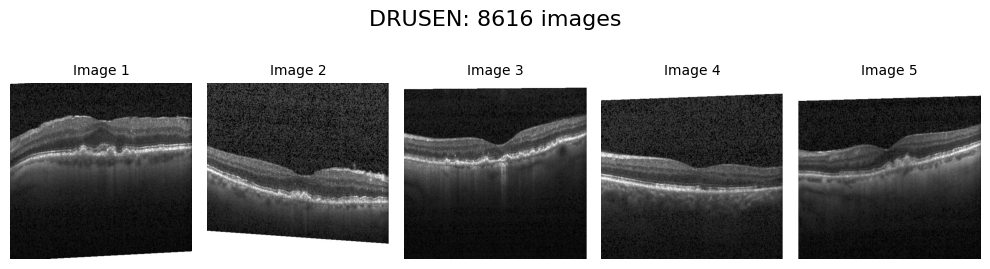

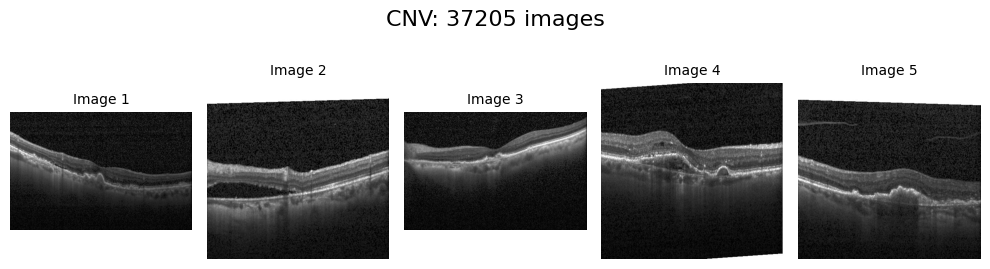

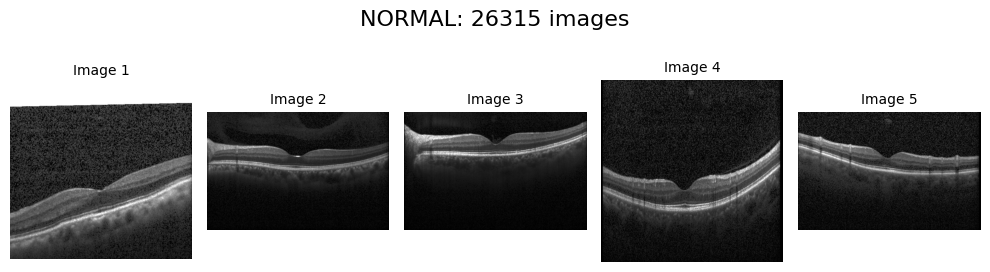

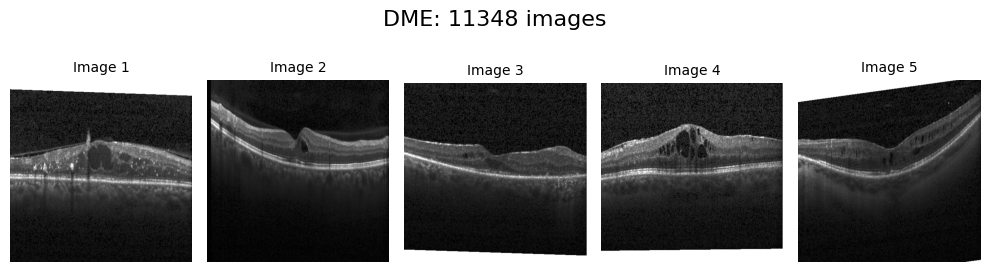

In [5]:
import os
import matplotlib.pyplot as plt
import cv2

train_path = ("/kaggle/input/kermany2018/OCT2017 /train")

# In the OCT2017 dir, 4 folders (CND, DME, DRUSEN, NORMAL)
for category in os.listdir(train_path):
    image_directory = os.path.join(train_path, category) # category = conditions (folder names in dataset)
    images = os.listdir(image_directory)[:5] # list of irectories path/CNV...

    fig, axes = plt.subplots(1, 5, figsize=(10,3))
    fig.suptitle(f"{category}: {len(os.listdir(image_directory))} images", fontsize=16) # Number of iamges in the train data set for each condition
    
    for i, file_name in enumerate(images):
        img_path = os.path.join(image_directory, file_name)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        axes[i].imshow(img, cmap='gray')
        axes[i].axis('off')
        axes[i].set_title(f"Image {i+1}", fontsize=10)

    plt.tight_layout()
    plt.show()

##### Augment Images & Prepare Data

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_SIZE = (IMG_HEIGHT, IMG_WIDTH)
BATCH_SIZE = 128


# For easier processing, pixel values are being normalized to a value between 0 and 1 from 0 and 256.
# images are augmented: rotated, scaled, stretched, or flipped

img_data_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

train_data = img_data_gen.flow_from_directory(
    train_path,
    target_size=IMG_SIZE,
    color_mode='grayscale',
    batch_size=BATCH_SIZE,
    class_mode='categorical', # More user friendly for only 4 options
    shuffle=True
)

# Avoid augmentation in test and validiation to reduce distortion
# Normalize pixel values only
test_val_gen = ImageDataGenerator(rescale=1./255)

# Turn shuffle to be false to keep test and val data ordered for later analysis
# could get away with it since dataset is not THAT big but this way is more rigerous

val_data = test_val_gen.flow_from_directory(
    val_path,
    target_size=IMG_SIZE,
    color_mode='grayscale',
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_data = test_val_gen.flow_from_directory(
    test_path,
    target_size=IMG_SIZE,
    color_mode='grayscale',
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)


Found 83484 images belonging to 4 classes.
Found 32 images belonging to 4 classes.
Found 968 images belonging to 4 classes.


#### View Augmented Images

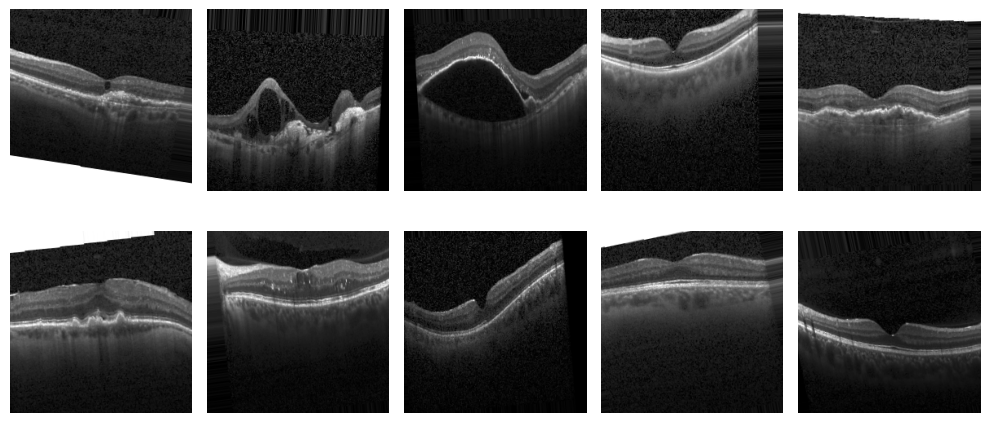

{'CNV': 0, 'DME': 1, 'DRUSEN': 2, 'NORMAL': 3}

In [7]:
import matplotlib.pyplot as plt

# Get a batch of images and labels
images, labels = next(train_data)

# Plot the first 10 images in the batch
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(images[i], cmap='gray')
    plt.axis('off')
plt.tight_layout()
plt.show()

train_data.class_indices

### Build Model

##### Use Convolutional Neural Network
Faster, lighter load with limited accuracy. Supports Grayscale. Custom Dense layers

In [8]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# 8 Layers
# Detect edges, curves, and patterns on a low level.
# Identify abstract and complex features
# Combine information with class output
model = Sequential([
    # 1 - Extract Low-Level Features 
    #     2 (3x3) filters that slide across img keeping opositive values
    Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 1)),

    # 2 - Streamline Representation
    #     take max value in each "window" (2x2) to mitigate overfitting
    MaxPooling2D((2,2)),

    # 3 - Second convlution to capture more complex features via more filters
    Conv2D(64, (3,3), activation='relu'),

    # 4 - Streamline
    MaxPooling2D((2,2)),

    # 5 - Flatten 3D output from the convolution layers and extract into 1D 
    Flatten(),

    # 6 - Combine Features to identify image from flattened features
    Dense(128, activation='relu'),

    # 7 - Drop half the neurons
    #     Mitigate Overfitting
    Dropout(0.5),

    # 8 - Predict which class the image belongs to
    Dense(4, activation='softmax')  # 4 classes (CNV, DME, DRUSEN, NORMAL)
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1748551563.551675      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1748551563.552357      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


##### Compile & Train the Model

In [9]:
from tensorflow.keras.optimizers import Adam

model.compile(
    optimizer=Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

##### Stop Model
Stop the model if the accuracy stops improving

In [10]:
from tensorflow.keras.callbacks import EarlyStopping

# Test both val_lass and val_accuracy

early_stop_loss = EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True,
    verbose=1
)

early_stop_acc = EarlyStopping(
    monitor='val_accuracy',
    patience=2,
    restore_best_weights=True,
    verbose=1
)

In [11]:
def build_model():
    model = Sequential([
        Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 1)),
        MaxPooling2D((2,2)),
        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D((2,2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(4, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


##### Model with early stopping on val_loss

In [12]:
model_loss = build_model()
history_loss = model_loss.fit(
    train_data,
    validation_data=val_data,
    epochs=10,
    callbacks=[early_stop_loss]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


I0000 00:00:1748551570.976689     128 service.cc:148] XLA service 0x7ccc240070a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748551570.977350     128 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1748551570.977377     128 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1748551571.281918     128 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/653 ━━━━━━━━━━━━━━━━━━━━ 2:27:36 14s/step - accuracy: 0.3281 - loss: 1.3674

I0000 00:00:1748551580.738872     128 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


653/653 ━━━━━━━━━━━━━━━━━━━━ 975s 1s/step - accuracy: 0.5413 - loss: 1.2161 - val_accuracy: 0.5000 - val_loss: 1.1385
Epoch 2/10
653/653 ━━━━━━━━━━━━━━━━━━━━ 505s 774ms/step - accuracy: 0.7289 - loss: 0.7382 - val_accuracy: 0.5000 - val_loss: 1.0323
Epoch 3/10
653/653 ━━━━━━━━━━━━━━━━━━━━ 479s 734ms/step - accuracy: 0.7485 - loss: 0.6819 - val_accuracy: 0.6250 - val_loss: 0.9756
Epoch 4/10
653/653 ━━━━━━━━━━━━━━━━━━━━ 474s 725ms/step - accuracy: 0.7680 - loss: 0.6373 - val_accuracy: 0.5625 - val_loss: 1.1101
Epoch 5/10
653/653 ━━━━━━━━━━━━━━━━━━━━ 472s 722ms/step - accuracy: 0.7745 - loss: 0.6160 - val_accuracy: 0.5938 - val_loss: 1.2200
Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 3.


##### Model with early stopping on val_accuracy

In [18]:
model_acc = build_model()
history_acc = model_acc.fit(
    train_data,
    validation_data=val_data,
    epochs=10,
    callbacks=[early_stop_acc]
)


Epoch 1/10
653/653 ━━━━━━━━━━━━━━━━━━━━ 489s 744ms/step - accuracy: 0.5669 - loss: 1.1202 - val_accuracy: 0.5625 - val_loss: 0.9775
Epoch 2/10
653/653 ━━━━━━━━━━━━━━━━━━━━ 460s 705ms/step - accuracy: 0.7365 - loss: 0.7154 - val_accuracy: 0.5625 - val_loss: 0.9477
Epoch 3/10
653/653 ━━━━━━━━━━━━━━━━━━━━ 471s 721ms/step - accuracy: 0.7577 - loss: 0.6596 - val_accuracy: 0.5938 - val_loss: 1.1130
Epoch 4/10
653/653 ━━━━━━━━━━━━━━━━━━━━ 471s 721ms/step - accuracy: 0.7764 - loss: 0.6137 - val_accuracy: 0.6562 - val_loss: 1.0413
Epoch 5/10
653/653 ━━━━━━━━━━━━━━━━━━━━ 473s 723ms/step - accuracy: 0.7898 - loss: 0.5799 - val_accuracy: 0.6875 - val_loss: 0.8139
Epoch 6/10
653/653 ━━━━━━━━━━━━━━━━━━━━ 480s 735ms/step - accuracy: 0.8041 - loss: 0.5430 - val_accuracy: 0.7188 - val_loss: 0.5153
Epoch 7/10
653/653 ━━━━━━━━━━━━━━━━━━━━ 471s 721ms/step - accuracy: 0.8122 - loss: 0.5242 - val_accuracy: 0.7812 - val_loss: 0.6130
Epoch 8/10
653/653 ━━━━━━━━━━━━━━━━━━━━ 480s 735ms/step - accuracy: 0.8249 -

##### Compare Training Curves

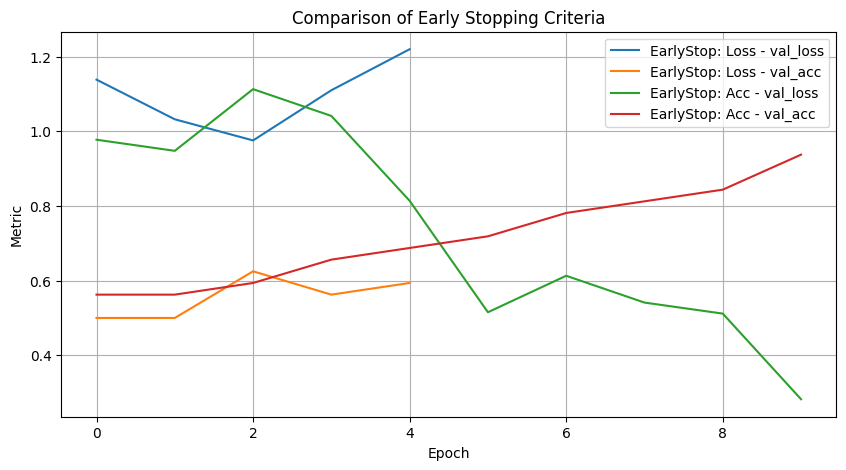

In [19]:
import matplotlib.pyplot as plt

def plot_history(hist, label):
    plt.plot(hist.history['val_loss'], label=f'{label} - val_loss')
    plt.plot(hist.history['val_accuracy'], label=f'{label} - val_acc')

plt.figure(figsize=(10,5))
plot_history(history_loss, 'EarlyStop: Loss')
plot_history(history_acc, 'EarlyStop: Acc')
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.title('Comparison of Early Stopping Criteria')
plt.legend()
plt.grid(True)
plt.show()


### Evaluation

##### Model Prediction Accuracy and Confidence

In [21]:
def compare_histories_with_markers(history_loss, history_acc):
    epochs_loss = len(history_loss.history['loss'])
    epochs_acc = len(history_acc.history['loss'])

    plt.figure(figsize=(14, 6))

    # Accuracy subplot
    plt.subplot(1, 2, 1)
    plt.plot(history_loss.history['accuracy'], label='Train Accuracy (loss monitor)', linestyle='--')
    plt.plot(history_loss.history['val_accuracy'], label='Val Accuracy (loss monitor)', marker='o')
    plt.axvline(x=epochs_loss - 1, color='blue', linestyle=':', label='Stopped (loss monitor)')

    plt.plot(history_acc.history['accuracy'], label='Train Accuracy (acc monitor)', linestyle='--')
    plt.plot(history_acc.history['val_accuracy'], label='Val Accuracy (acc monitor)', marker='s')
    plt.axvline(x=epochs_acc - 1, color='orange', linestyle=':', label='Stopped (acc monitor)')

    plt.title('Accuracy Comparison')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Loss subplot
    plt.subplot(1, 2, 2)
    plt.plot(history_loss.history['loss'], label='Train Loss (loss monitor)', linestyle='--')
    plt.plot(history_loss.history['val_loss'], label='Val Loss (loss monitor)', marker='o')
    plt.axvline(x=epochs_loss - 1, color='blue', linestyle=':', label='Stopped (loss monitor)')

    plt.plot(history_acc.history['loss'], label='Train Loss (acc monitor)', linestyle='--')
    plt.plot(history_acc.history['val_loss'], label='Val Loss (acc monitor)', marker='s')
    plt.axvline(x=epochs_acc - 1, color='orange', linestyle=':', label='Stopped (acc monitor)')

    plt.title('Loss Comparison')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

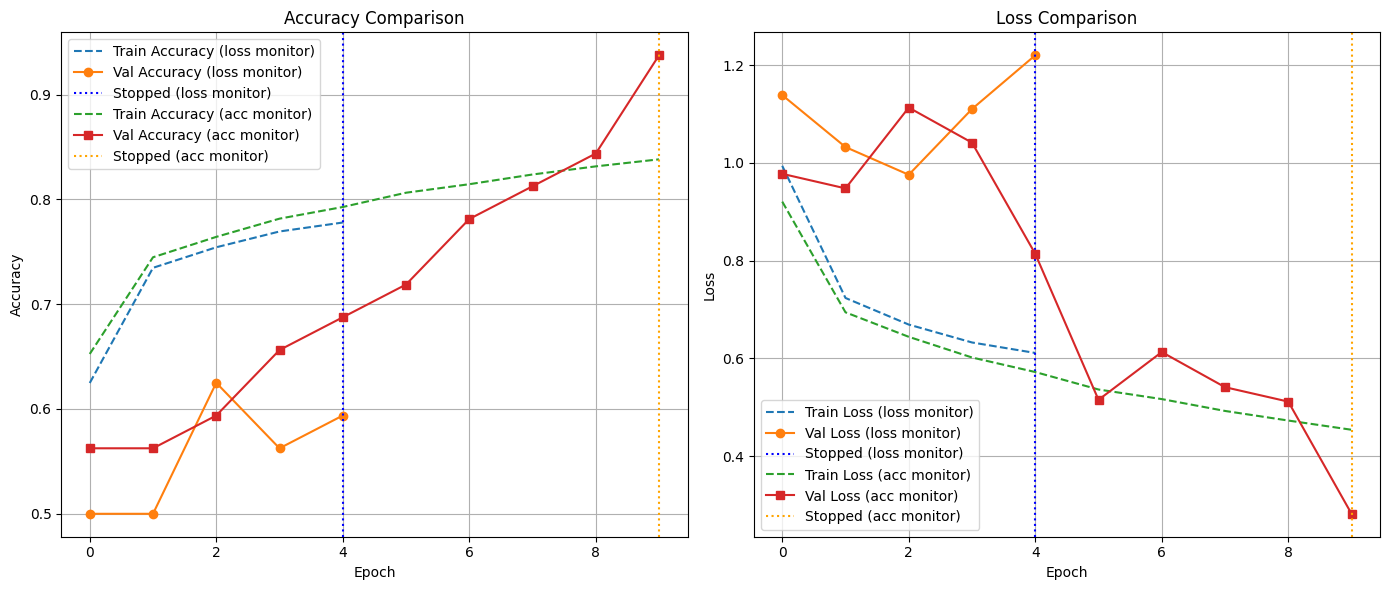

In [22]:
compare_histories_with_markers(history_loss, history_acc)

##### Confusion Matrix

Get Predictions and True Labels

In [24]:
import numpy as np
# Predict on test set
# Model 1: trained with early_stop on val_loss
y_pred_loss = np.argmax(model_loss.predict(test_data), axis=1)

# Reset test_data generator to ensure same order
test_data.reset()

# Model 2: trained with early_stop on val_accuracy
y_pred_acc = np.argmax(model_acc.predict(test_data), axis=1)

# Ground truth
y_true = test_data.classes
class_names = list(test_data.class_indices.keys())


8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 267ms/step


Create Matrix

In [25]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_comparison(y_true, y_pred1, y_pred2, class_names, labels=("Model 1", "Model 2")):
    cm1 = confusion_matrix(y_true, y_pred1)
    cm2 = confusion_matrix(y_true, y_pred2)

    plt.figure(figsize=(14, 6))

    # Model 1
    plt.subplot(1, 2, 1)
    sns.heatmap(cm1, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix: {labels[0]}')
    plt.xlabel('Predicted')
    plt.ylabel('True')

    # Model 2
    plt.subplot(1, 2, 2)
    sns.heatmap(cm2, annot=True, fmt='d', cmap='Greens',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix: {labels[1]}')
    plt.xlabel('Predicted')
    plt.ylabel('True')

    plt.tight_layout()
    plt.show()


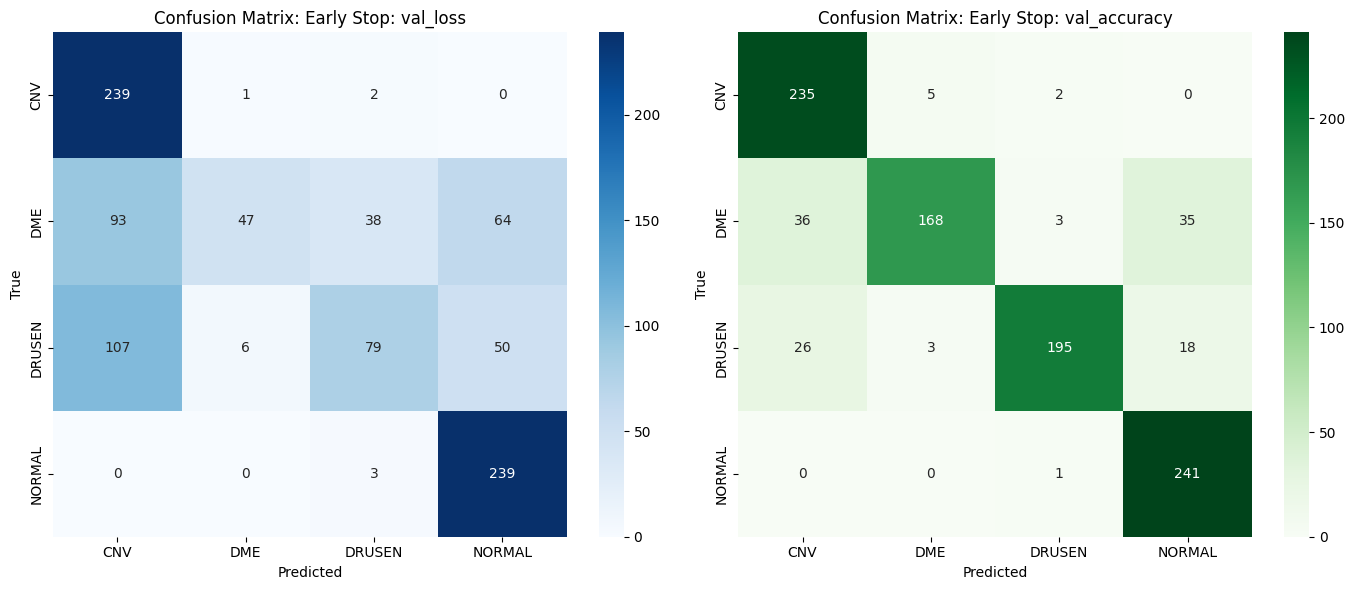

In [26]:
plot_confusion_comparison(
    y_true,
    y_pred_loss,
    y_pred_acc,
    class_names,
    labels=("Early Stop: val_loss", "Early Stop: val_accuracy")
)


Classification Report

In [28]:
from sklearn.metrics import classification_report

print("=== Classification Report (val_loss monitor) ===")
print(classification_report(y_true, y_pred_loss, target_names=class_names))

print("\n=== Classification Report (val_accuracy monitor) ===")
print(classification_report(y_true, y_pred_acc, target_names=class_names))


=== Classification Report (val_loss monitor) ===
              precision    recall  f1-score   support

         CNV       0.54      0.99      0.70       242
         DME       0.87      0.19      0.32       242
      DRUSEN       0.65      0.33      0.43       242
      NORMAL       0.68      0.99      0.80       242

    accuracy                           0.62       968
   macro avg       0.68      0.62      0.56       968
weighted avg       0.68      0.62      0.56       968


=== Classification Report (val_accuracy monitor) ===
              precision    recall  f1-score   support

         CNV       0.79      0.97      0.87       242
         DME       0.95      0.69      0.80       242
      DRUSEN       0.97      0.81      0.88       242
      NORMAL       0.82      1.00      0.90       242

    accuracy                           0.87       968
   macro avg       0.88      0.87      0.86       968
weighted avg       0.88      0.87      0.86       968

